In [1]:
import stim
import numpy as np
from numpy.linalg import matrix_power, matrix_rank
import matplotlib.pyplot as plt
from mec import make_circle
import galois
from scipy.sparse import lil_matrix
import os
from ldpc import bposd_decoder
from result import Result, save_new_res, res_to_line
from tqdm import tqdm

In [25]:
code = [12,3,9,1,2,0,7,2,3,12,2,1]
# code = [12,5,11,2,3,0,10,11,5,12,2,2]
# code = [12,3,9,1,2,0,10,11,3,12,2,2]

# code = [15,3,12,2,1,0,11,4,3,15,2,0]
# code = [9,5,8,4,1,5,8,7,5,9,2,1]
code = [9,5,8,1,4,0,8,7,5,9,2,1]
# code = [12,5,11,4,1,5,1,2,5,12,2,1,1.5113164112995061]

# 0.001 error rate
muls001=np.array([0.,0.,1,0.,4.29574973,0.,3.72796993,0.,3.72677149,0.,3.89005214,0.,3.99232483,0.,4.06567307,0.,4.50056257,0.,4.34609584,0.,4.17703894,0.,4.67106587,0.,4.57802336,0.,4.62997696,0.,5.65038511,0.,5.27687367,0.,6.39057363,0.,5.62583295,0.,6.25768488,0.,7.30176588,0.,6.79337286,0.,7.34345098,0.,7.19368032,0.,7.85836973,0.,8.45210287,0.,8.09274835])
probs=np.array([0.,0.,1,0.,0.98935,0.,0.98445,0.,0.9794,0.,0.97428,0.,0.96936,0.,0.96417,0.,0.95988,0.,0.95488,0.,0.94804,0.,0.94411,0.,0.93927,0.,0.93305,0.,0.93091,0.,0.92479,0.,0.92167,0.,0.91542,0.,0.91088,0.,0.90663,0.,0.90235,0.,0.89876,0.,0.89245,0.,0.89077,0.,0.88617,0.,0.8798])

In [26]:
def cyclic_shift_matrix(l):
    arr = np.eye(l, dtype=int)
    return np.roll(arr, axis=1, shift=1)

ell = code[0]
m = code[1]

x = np.kron(cyclic_shift_matrix(ell), np.eye(m))
y = np.kron(np.eye(ell), cyclic_shift_matrix(m))

A1 = matrix_power(x, code[2])
A2 = matrix_power(y, code[3])
A3 = matrix_power(y, code[4])
A = ( A1 + A2 + A3 ) % 2

B1 = matrix_power(y, code[5])
B2 = matrix_power(x, code[6])
B3 = matrix_power(x, code[7])
B = ( B1 + B2 + B3 ) % 2

Hx = np.hstack([A, B]).astype(int)
Hz = np.hstack([B.T, A.T]).astype(int)

GF = galois.GF(2)
arr = GF(Hz.T)
k = 2 * (Hz.T.shape[1] - matrix_rank(arr))

In [27]:
def par2gen(H):
    GF = galois.GF(2)
    gfH = GF(H)
    gfH_rank = np.linalg.matrix_rank(gfH)

    rref_H = gfH.row_reduce()

    swaps = []
    col_H = rref_H.copy()
    for i in range(gfH_rank):
        inds = np.where(col_H[i])[0]
        pivot = inds[0]
        col_H[:,[i,pivot]] = col_H[:,[pivot,i]]
        swaps.append((i,pivot))

    col_H = col_H[:gfH_rank]
    col_G = GF(np.hstack([col_H[:,gfH_rank:].T, np.eye(H.shape[1]-gfH_rank, dtype=int)]))

    G = col_G.copy()
    for swap in swaps[::-1]:
        G[:,[swap[1],swap[0]]] = G[:,[swap[0],swap[1]]]

    if (np.any(G @ rref_H[:gfH_rank].T) or np.any(col_G @ col_H.T)):
        print("FAILED")
        return
    return (np.array(G, dtype=int), np.array(col_G, dtype=int))

def commute(x, z, n):
    # 0 if commute, 1 if anticommute
    x1 = x[:n]
    x2 = x[n:]
    z1 = z[:n]
    z2 = z[n:]
    return (x1 @ z2 % 2) ^ (x2 @ z1 % 2)

def SGSOP(Gx, Gz, n):
    # symplectic gram-schmidt orthogonalization procedure
    sym_Gx = np.hstack([Gx, np.zeros(Gx.shape, dtype=int)])
    sym_Gz = np.hstack([np.zeros(Gz.shape, dtype=int), Gz])
    sym_G = np.vstack([sym_Gx, sym_Gz])
    logicals = []
    generators = []

    while(sym_G.shape[0]):
        g1 = sym_G[0]

        commutes = True
        for i in range(1, sym_G.shape[0]-1):
            g2 = sym_G[i]
            if (commute(g1,g2,n)):
                logicals.append((g1, g2))
                sym_G = np.delete(sym_G, [0, i], axis=0)

                for j in range(sym_G.shape[0]):
                    gj = sym_G[j]
                    sym_G[j] = gj ^ (commute(gj,g2,n) * g1) ^ (commute(gj,g1,n) * g2)
                commutes = False
                break

        if commutes:
            generators.append(g1)
            sym_G = np.delete(sym_G, 0, axis=0)

    return (logicals, generators)

In [28]:
def get_logicals(gen_type=False):
    n = Hx.shape[1]
    Gx, col_Gx = par2gen(Hx)
    Gz, col_Gz = par2gen(Hz)
    logicals, generators = SGSOP(Gx, Gz, n)

    logX = np.array([l[1][n:] for l in logicals])
    logZ = np.array([l[0][:n] for l in logicals])

    if gen_type: return logX
    else: return logZ

In [29]:
def manhattan(qbts):
    p, q = qbts
    return np.abs(p[0]-q[0])+np.abs(p[1]-q[1])

def embed_code(code, init):
    emb_m, emb_ell, A_ind, B_ind = code

    lattice = np.empty((2*emb_m, 2*emb_ell), dtype=object)
    lattice[0][0] = f"x{init}"

    # As = [[A1, A2.T], [A2, A3.T], [A1, A3.T]]
    # Bs = [[B1, B2.T], [B2, B3.T], [B1, B3.T]]
    As = [[A1, A2.T], [A2, A1.T], [A2, A3.T], [A3, A2.T], [A1, A3.T], [A3, A1.T]]
    Bs = [[B1, B2.T], [B2, B1.T], [B2, B3.T], [B3, B2.T], [B1, B3.T], [B3, B1.T]]

    def get_nbr(i, j):
        if (i % 2 == 0):
            if (j % 2 == 0):
                return "x"
            else:
                return "r"
        else:
            if (j % 2 == 0):
                return "l"
            else:
                return "z"

    for i in range(2*emb_m - 1):
        for j in range(2*emb_ell):
            curr_ind = int(lattice[i][j][1:])

            if (i % 2 == 0):
                tmp_A = As[A_ind][1]
            else:
                tmp_A = As[A_ind][0]
            if (j % 2 == 0):
                tmp_B = Bs[B_ind][1]
            else:
                tmp_B = Bs[B_ind][0]

            lattice[(i+1)%(2*emb_m)][j] = f"{get_nbr((i+1)%(2*emb_m), j)}{np.where(tmp_A @ np.eye(m*ell)[curr_ind])[0][0]}"
            lattice[i][(j+1)%(2*emb_ell)] = f"{get_nbr(i, (j+1)%(2*emb_ell))}{np.where(tmp_B @ np.eye(m*ell)[curr_ind])[0][0]}"

    for i in range(2*emb_m):
        for j in range(2*emb_ell):
            if (lattice[i][j][0] == "z"):
                lattice[i][j] = f"z{int(lattice[i][j][1:]) + m*ell}"
            elif (lattice[i][j][0] == "r"):
                lattice[i][j] = f"r{int(lattice[i][j][1:]) + m*ell}"

    return lattice

lattice = embed_code((code[8],code[9],code[10],code[11]), 0)

all_qbts = {}

qbts = np.array([None for i in range(2*m*ell)])
for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "r" or lattice[i][j][0] == "l":
            all_qbts[(i,j)] = int(lattice[i][j][1:])
            qbts[int(lattice[i][j][1:])] = (i, j)
x_checks = np.array([None for i in range(m*ell)])
z_checks = np.array([None for i in range(m*ell)])

for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "x":
            all_qbts[(i,j)] = int(lattice[i][j][1:]) + 2*m*ell
            x_checks[int(lattice[i][j][1:])] = (i, j)
        elif lattice[i][j][0] == "z":
            all_qbts[(i,j)] = int(lattice[i][j][1:]) + 2*m*ell
            z_checks[int(lattice[i][j][1:])-(m*ell)] = (i, j)

x_rs = []
z_rs = []
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    x_rs.append(make_circle(gen_qbts)[2])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    z_rs.append(make_circle(gen_qbts)[2])

lr_x_checks = np.array([], dtype=int)
sr_x_checks = np.array([], dtype=int)
lr_z_checks = np.array([], dtype=int)
sr_z_checks = np.array([], dtype=int)

z_check_succ_probs = np.ones(m*ell)
x_check_succ_probs = np.ones(m*ell)

for i, x_check in enumerate(x_checks):
    gen_qbts = qbts[np.where(Hx[i])[0]]

    nonlocal_qbts = []
    if (x_rs[i] > (min(x_rs)+np.std(x_rs))):
        lr_x_checks = np.append(lr_x_checks, i)
    else:
        sr_x_checks = np.append(sr_x_checks, i)

    for qbt in gen_qbts:
        x_check_succ_probs[i] *= probs[manhattan([x_check, qbt])+1]

for i, z_check in enumerate(z_checks):
    gen_qbts = qbts[np.where(Hz[i])[0]]

    nonlocal_qbts = []
    if (z_rs[i] > min(z_rs)+np.std(z_rs)):
        lr_z_checks = np.append(lr_z_checks, i)
    else:
        sr_z_checks = np.append(sr_z_checks, i)

    for qbt in gen_qbts:
        z_check_succ_probs[i] *= probs[manhattan([z_check, qbt])+1]

adv = sum(np.array(x_rs)[lr_x_checks]) / sum(np.array(x_rs)[sr_x_checks])
print(adv)

0.7252941856903945


In [30]:
def measure_x_checks(checks, p, scale=False):
    c = stim.Circuit()
    c.append("H", [all_qbts[x_checks[x_check]] for x_check in checks])
    c.append("DEPOLARIZE1", [all_qbts[x_checks[x_check]] for x_check in checks], p)
    for x in checks:
        gen_qbts = qbts[np.where(Hx[x])[0]]
        for qbt in gen_qbts:
            path_qbts = [all_qbts[x_checks[x]], all_qbts[qbt]]
            c.append("CNOT", path_qbts)
            if scale:
                c.append("DEPOLARIZE2", path_qbts, p*muls001[manhattan([x_checks[x], qbt])+1])
            else:
                c.append("DEPOLARIZE2", path_qbts, p)
    c.append("H", [all_qbts[x_checks[x_check]] for x_check in checks])
    c.append("DEPOLARIZE1", [all_qbts[x_checks[x_check]] for x_check in checks], p)
    return c

def measure_z_checks(checks, p, scale=False):
    c = stim.Circuit()
    for z in checks:
        gen_qbts = qbts[np.where(Hz[z])[0]]
        for qbt in gen_qbts:
            path_qbts = [all_qbts[qbt], all_qbts[z_checks[z]]]
            c.append("CNOT", path_qbts)
            if scale:
                c.append("DEPOLARIZE2", path_qbts, p*muls001[manhattan([qbt, z_checks[z]])+1])
            else:
                c.append("DEPOLARIZE2", path_qbts, p)
    return c

def all_checks():
    c = stim.Circuit()
    c += measure_z_checks(sr_z_checks, False)
    c += measure_z_checks(lr_z_checks, False)
    c += measure_x_checks(sr_x_checks, False)
    c += measure_x_checks(lr_x_checks, False)
    return c

In [31]:
class Simulation:
    def __init__(self, num_rounds, lr_time):
        self.num_rounds = num_rounds
        self.lr_time = lr_time

        self.prev_meas_z = np.arange(1, m*ell+1, dtype=int)
        self.prev_meas_x = np.arange(m*ell+1, 2*m*ell+1,  dtype=int)
        self.curr_meas_z = np.zeros(m*ell, dtype=int)
        self.curr_meas_x = np.zeros(m*ell, dtype=int)

        self.route_confirmation_z = np.ones(m*ell, dtype=int)
        self.route_confirmation_z[lr_z_checks] = 0
        self.route_confirmation_x = np.ones(m*ell, dtype=int)
        self.route_confirmation_x[lr_x_checks] = 0
        self.detector_history = np.zeros(m*ell)

        self.c = stim.Circuit()
        for key, value in all_qbts.items():
            self.c.append("QUBIT_COORDS", value, (key[0],key[1],0))
            self.c.append("QUBIT_COORDS", value+(4*m*ell), (key[0],key[1],1))
        self.c.append("R", [qbt for qbt in all_qbts.values()])
        self.c.append("R", [qbt+(4*m*ell) for qbt in all_qbts.values()])

        self.c += all_checks().without_noise()
        self.c.append("MR", [all_qbts[z_check] for z_check in z_checks])
        self.c.append("MR", [all_qbts[x_check] for x_check in x_checks])

    def detectors(self, type):
        num_meas = self.c.num_measurements
        if not type:
            for i, z_check in enumerate(self.curr_meas_z):
                coord = z_checks[i]
                if z_check:
                    self.c.append("DETECTOR", [stim.target_rec(self.curr_meas_z[i]-num_meas-1), stim.target_rec(self.prev_meas_z[i]-num_meas-1)], (coord[0], coord[1], 0))
                    self.prev_meas_z[i] = self.curr_meas_z[i]
                    self.curr_meas_z[i] = 0
        else:
            pass # x type checks

    def observables(self, type):
        for i, logical in enumerate(get_logicals(type)):
            incl_qbts = np.where(logical)[0]
            incl_qbts = [-j-1 for j in incl_qbts]
            self.c.append("OBSERVABLE_INCLUDE", [stim.target_rec(j) for j in incl_qbts], i)

    def sr_round(self, with_gate_noise=True, with_synd_noise=True):
        curr_sr_z_checks = sr_z_checks[self.route_confirmation_z[sr_z_checks]==1]
        curr_sr_x_checks = sr_x_checks[self.route_confirmation_x[sr_x_checks]==1]
        self.c += measure_z_checks(curr_sr_z_checks, 0.001 if with_gate_noise else 0, scale=True)
        self.c += measure_x_checks(curr_sr_x_checks, 0.001 if with_gate_noise else 0, scale=True)

        if with_synd_noise: self.c.append("X_ERROR", [all_qbts[z_checks[z_check]] for z_check in curr_sr_z_checks], 0.001)
        if with_synd_noise: self.c.append("X_ERROR", [all_qbts[x_checks[x_check]] for x_check in curr_sr_x_checks], 0.001)

        for i, z_check in enumerate(curr_sr_z_checks):
            self.c.append("M", all_qbts[z_checks[z_check]])
            self.curr_meas_z[z_check] = self.c.num_measurements
        for i, z_check in enumerate(sr_z_checks):
            self.c.append("R", all_qbts[z_checks[z_check]])
        for i, x_check in enumerate(curr_sr_x_checks):
            self.c.append("M", all_qbts[x_checks[x_check]])
            self.curr_meas_x[x_check] = self.c.num_measurements
        for i, x_check in enumerate(sr_x_checks):
            self.c.append("R", all_qbts[x_checks[x_check]])

        if with_synd_noise: self.c.append("X_ERROR", [all_qbts[z_checks[z_check]] for z_check in sr_z_checks], 0.001)
        if with_synd_noise: self.c.append("X_ERROR", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks], 0.001)


    def lr_round(self, with_gate_noise=True, with_synd_noise=True):
        curr_sr_z_checks = sr_z_checks[self.route_confirmation_z[sr_z_checks]==1]
        curr_sr_x_checks = sr_x_checks[self.route_confirmation_x[sr_x_checks]==1]
        curr_lr_z_checks = lr_z_checks[self.route_confirmation_z[lr_z_checks]==1]
        curr_lr_x_checks = lr_x_checks[self.route_confirmation_x[lr_x_checks]==1]

        curr_z_checks = np.concatenate([curr_sr_z_checks, curr_lr_z_checks])
        curr_x_checks = np.concatenate([curr_sr_x_checks, curr_lr_x_checks])
        all_z_checks = np.concatenate([sr_z_checks, lr_z_checks])
        all_x_checks = np.concatenate([sr_x_checks, lr_x_checks])

        self.c += measure_z_checks(curr_sr_z_checks, 0.001 if with_gate_noise else 0, scale=True)
        self.c += measure_z_checks(curr_lr_z_checks, 0.001 if with_gate_noise else 0, scale=True)
        self.c += measure_x_checks(curr_sr_x_checks, 0.001 if with_gate_noise else 0, scale=True)
        self.c += measure_x_checks(curr_lr_x_checks, 0.001 if with_gate_noise else 0, scale=True)

        if with_synd_noise: self.c.append("X_ERROR", [all_qbts[z_checks[z_check]] for z_check in all_z_checks], 0.001)
        if with_synd_noise: self.c.append("X_ERROR", [all_qbts[x_checks[x_check]] for x_check in all_x_checks], 0.001)

        for i, z_check in enumerate(curr_z_checks):
            self.c.append("M", all_qbts[z_checks[z_check]])
            self.curr_meas_z[z_check] = self.c.num_measurements
        for i, z_check in enumerate(all_z_checks):
            self.c.append("R", all_qbts[z_checks[z_check]])
        for i, x_check in enumerate(curr_x_checks):
            self.c.append("M", all_qbts[x_checks[x_check]])
            self.curr_meas_x[x_check] = self.c.num_measurements
        for i, x_check in enumerate(all_x_checks):
            self.c.append("R", all_qbts[x_checks[x_check]])

        if with_synd_noise: self.c.append("X_ERROR", [all_qbts[z_checks[z_check]] for z_check in all_z_checks], 0.001)
        if with_synd_noise: self.c.append("X_ERROR", [all_qbts[x_checks[x_check]] for x_check in all_x_checks], 0.001)


    def simulate(self):
        for i in range(1,self.num_rounds+1):
            self.c.append("SHIFT_COORDS", [], (0,0,1))
            if (i%self.lr_time==0):
                self.c.append("DEPOLARIZE1", [all_qbts[qbt] for qbt in qbts], 0.005+(0.005*adv))
                self.route_confirmation_z[sr_z_checks] = [1 if np.random.random() < z_check_succ_probs[z] else 0 for z in sr_z_checks]
                self.route_confirmation_z[lr_z_checks] = [1 if np.random.random() < z_check_succ_probs[z] else 0 for z in lr_z_checks]
                self.route_confirmation_x[sr_x_checks] = [1 if np.random.random() < x_check_succ_probs[x] else 0 for x in sr_x_checks]
                self.route_confirmation_x[lr_x_checks] = [1 if np.random.random() < x_check_succ_probs[x] else 0 for x in lr_x_checks]
                self.detector_history = np.vstack([self.detector_history, self.route_confirmation_z])
                self.lr_round()
            else:
                self.c.append("DEPOLARIZE1", [all_qbts[qbt] for qbt in qbts], 0.005)
                self.route_confirmation_z[sr_z_checks] = [1 if np.random.random() < z_check_succ_probs[z] else 0 for z in sr_z_checks]
                self.route_confirmation_z[lr_z_checks] = 0
                self.route_confirmation_x[sr_x_checks] = [1 if np.random.random() < x_check_succ_probs[x] else 0 for x in sr_x_checks]
                self.route_confirmation_x[lr_x_checks] = 0
                self.detector_history = np.vstack([self.detector_history, self.route_confirmation_z])
                self.sr_round()
            self.detectors(False)

        self.route_confirmation_z = np.ones(m*ell)
        self.route_confirmation_x = np.ones(m*ell)
        self.detector_history = np.vstack([self.detector_history, self.route_confirmation_z])
        self.lr_round(with_gate_noise=False, with_synd_noise=False)
        self.detectors(False)

        self.c.append("M",[all_qbts[qbt] for qbt in qbts[::-1]])
        self.observables(False)

In [32]:
s = Simulation(10, 5)
s.simulate()
c = s.c

In [33]:
detector_sampler = c.without_noise().compile_detector_sampler()
one_sample = detector_sampler.sample(shots=1, append_observables=True)[0]

ind = 0
print("round\tnum\t")
for i in range(1,s.num_rounds+2):
    curr_checks = s.detector_history[i]
    num_checks = np.count_nonzero(curr_checks)
    timeslice = one_sample[ind:ind+num_checks]
    j = 0
    print(f"{i}\t{num_checks}\t", end="")
    for check in curr_checks:
        if check:
            if timeslice[j]: print("!", end="")
            else: print("_", end="")
            j += 1
        else: print(" ", end="")
    ind += num_checks
    print()
print()
print("observables\t", end="")
timeslice = one_sample[-k:]
print("".join("!" if e else "_" for e in timeslice))

round	num	
1	33	_____ _________ ___________________          
2	33	_ ____________________ ____________          
3	34	_____________________ _____________          
4	35	___________________________________          
5	45	_____________________________________________
6	35	___________________________________          
7	34	_____________________ _____________          
8	33	_________ _________ _______________          
9	34	_____________ _____________________          
10	43	______ ____________________________ _________
11	45	_____________________________________________

observables	________


In [106]:
lr_round = 5
res_file_name = f"../results/{ell}_{m}/full_circuit_results_laptop_{lr_round}.res"
rs = []

num_iters = 1000
p_mask = len(lr_x_checks)/Hx.shape[0]


for T in range(10, 30, 10):
    rs = []

    s = Simulation(T, lr_round)
    s.simulate()
    c = s.c

    sampler = c.compile_detector_sampler()
    dem = c.detector_error_model()
    pcm = lil_matrix((dem.num_detectors, dem.num_errors), dtype=np.uint8)
    lcm = lil_matrix((dem.num_observables, dem.num_errors), dtype=np.uint8)

    errors = []
    channel_probs = [e.args_copy()[0] for e in c.detector_error_model() if e.type=="error"]
    for i, error_event in enumerate(c.explain_detector_error_model_errors()):
        dets = [det.dem_target.val for det in error_event.dem_error_terms if det.dem_target.is_relative_detector_id()]
        obs = [ob.dem_target.val for ob in error_event.dem_error_terms if ob.dem_target.is_logical_observable_id()]
        pcm[[dets],i] = 1
        lcm[[obs],i] = 1

    print(pcm.shape)
    print(lcm.shape)

    bposd_dec = bposd_decoder(
        pcm, # the parity check matrix
        channel_probs=channel_probs, #assign error_rate to each qubit. This will override "error_rate" input variable
        max_iter=pcm.shape[1], #the maximum number of iterations for BP)
        bp_method="ms",
        ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
        osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
        osd_order=min(pcm.shape[0],10) #the osd search depth
    )


    for i in tqdm(range(num_iters)):
        detection_events, observable_flips = sampler.sample(1, separate_observables=True)
        guessed_errors = bposd_dec.decode(detection_events[0])
        guessed_obs = (lcm @ guessed_errors) % 2
        success = np.all(observable_flips[0].astype(int) == guessed_obs)
        res = Result(T, k, ell, m,
                            code[2],code[3],code[4], code[5],code[6],code[7],
                            code[8],code[9],code[10],code[11],1.4749672794047808,
                            0.001, p_mask, 1, int(success))
        rs.append(res)

    save_new_res(res_file_name, rs)

(398, 3676)
(8, 3676)


  4%|▎         | 37/1000 [00:01<00:26, 36.38it/s]


KeyboardInterrupt: 

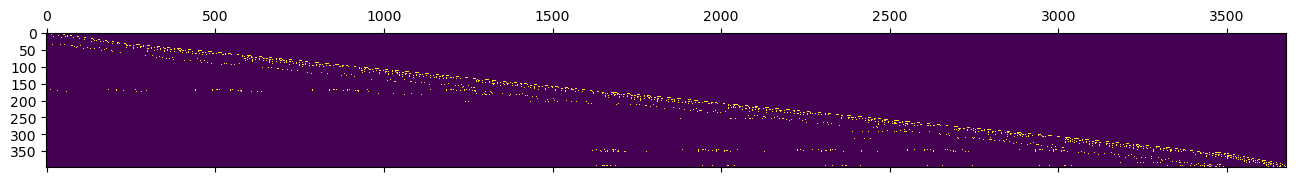

In [107]:
plt.matshow(pcm.A)

In [117]:
chunk_size = 1000
num_chunks = (pcm.shape[1]+chunk_size-1) // chunk_size
decoders = []
pcm_chunks = []
channel_probs_chunks = []

for jj in range(num_chunks):
    start_col = jj * chunk_size
    end_col = (jj+1) * chunk_size
    # small_pcm = pcm[:, start_col:end_col]
    # pcm_chunks.append(small_matrix)
    # channel_probs_chunks.append(channel_probs[start_col:end_col])

    tmp_dec = bposd_decoder(
        pcm[:, start_col:end_col], # the parity check matrix
        channel_probs=channel_probs[start_col:end_col], #assign error_rate to each qubit. This will override "error_rate" input variable
        max_iter=chunk_size, #the maximum number of iterations for BP)
        bp_method="ms",
        ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
        osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
        osd_order=min(pcm.shape[0],10) #the osd search depth
    )
    decoders.append(tmp_dec)

In [118]:
detection_events, observable_flips = sampler.sample(1, separate_observables=True)
# guessed_errors = bposd_dec.decode(detection_events[0])

guessed_chunk_errors = [d.decode(detection_events[0]) for d in decoders]
guessed_errors = np.concatenate(guessed_chunk_errors)
guessed_obs = (lcm @ guessed_errors) % 2
success = np.all(observable_flips[0].astype(int) == guessed_obs)
print(guessed_obs, observable_flips)

[0 1 0 1 0 0 0 1] [[ True False  True False  True  True False  True]]


In [64]:
np.concatenate(guessed_chunk_errors)

array([0, 0, 0, ..., 0, 0, 0])